## **Problem Statement**

In this tutorial, we will work with the **Rossmann Store Sales** dataset to learn and apply gradient boosting methods for real-world forecasting.
Rossmann operates over 3,000 drug stores across several European countries, and accurate sales forecasts are essential for staff planning, inventory decisions, and store management.

The dataset we use **is not the official Kaggle competition dataset**.
It is a publicly shared copy uploaded by a Kaggle community user:

📌 **Dataset Source:**
**"Rossmann Store Sales" – uploaded by Kaggle user Pratyusha Kar**
[https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales](https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales)

Although this is not the original competition page, the data closely follows the structure of the original challenge and is perfectly suitable for learning and experimentation.

Our goal remains the same as the original forecasting task:
to build a machine learning model that **predicts the `"Sales"` column** based on historical data, promotions, holidays, competition, seasonality, and store metadata.

This project focuses on:

* **Data preprocessing**
* **Feature engineering**
* **Handling time-related data**
* **Training gradient boosting models** (XGBoost, LightGBM, CatBoost)
* **Evaluating predictions**
* **Understanding real-world forecasting challenges**

In [162]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set(font_scale=1.1)


In [163]:
ross_df = pd.read_csv('train.csv',low_memory=False)
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv',low_memory=False)


In [261]:
submission_df = pd.read_csv('sample_submission.csv')

Let's merge the information from `store_df` into `train_df` and `test_df`.

In [164]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [165]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

> **EXERCISE**: Perform exploratory data analysis and visualization on the dataset. Study the distribution of values in each column, and their relationship with the target column `Sales`.

## Basic Inspection & Date Handling


In [166]:
# Basic overview
print(merged_df.shape)
print(merged_df.dtypes)
merged_df.head()

(1017209, 18)
Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [167]:
merged_df.isna().sum().sort_values(ascending=False)

Promo2SinceWeek              508031
PromoInterval                508031
Promo2SinceYear              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
DayOfWeek                         0
Store                             0
Date                              0
Sales                             0
StoreType                         0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Assortment                        0
Promo2                            0
dtype: int64

In [168]:
# Convert Date to datetime
merged_df["Date"] = pd.to_datetime(merged_df["Date"], format="%Y-%m-%d")

# Sort by Store + Date
merged_df = merged_df.sort_values(["Store", "Date"]).reset_index(drop=True)

## Target Variable: Sales

In [169]:
# Descriptive stats
merged_df["Sales"].describe()


count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

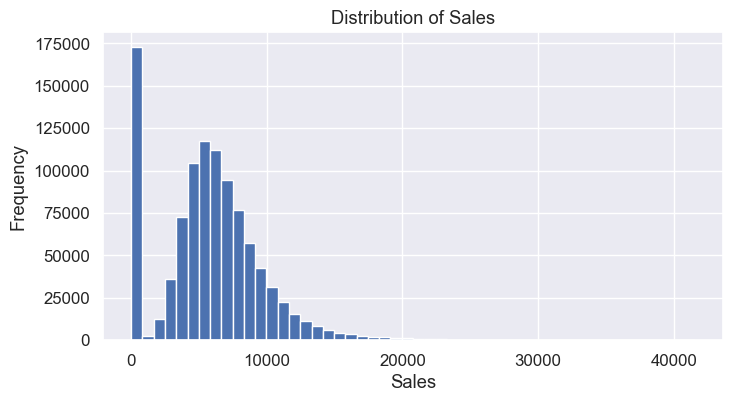

In [170]:
plt.figure(figsize=(8, 4))
plt.hist(merged_df["Sales"], bins=50)
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title("Distribution of Sales")
plt.show()


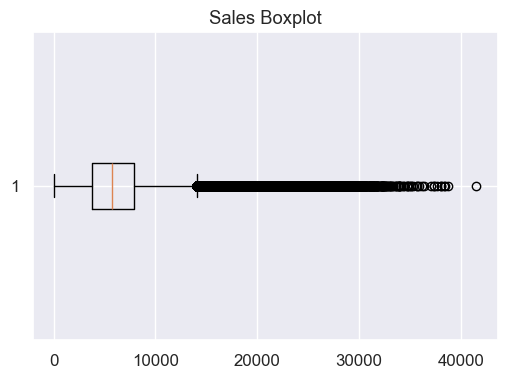

In [171]:
plt.figure(figsize=(6, 4))
plt.boxplot(merged_df["Sales"], vert=False)
plt.title("Sales Boxplot")
plt.show()



Sales on closed days

In [172]:
closed = merged_df[merged_df["Open"] == 0]
closed["Sales"].describe()


count    172817.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Sales, dtype: float64

## Numeric Features & Correlation

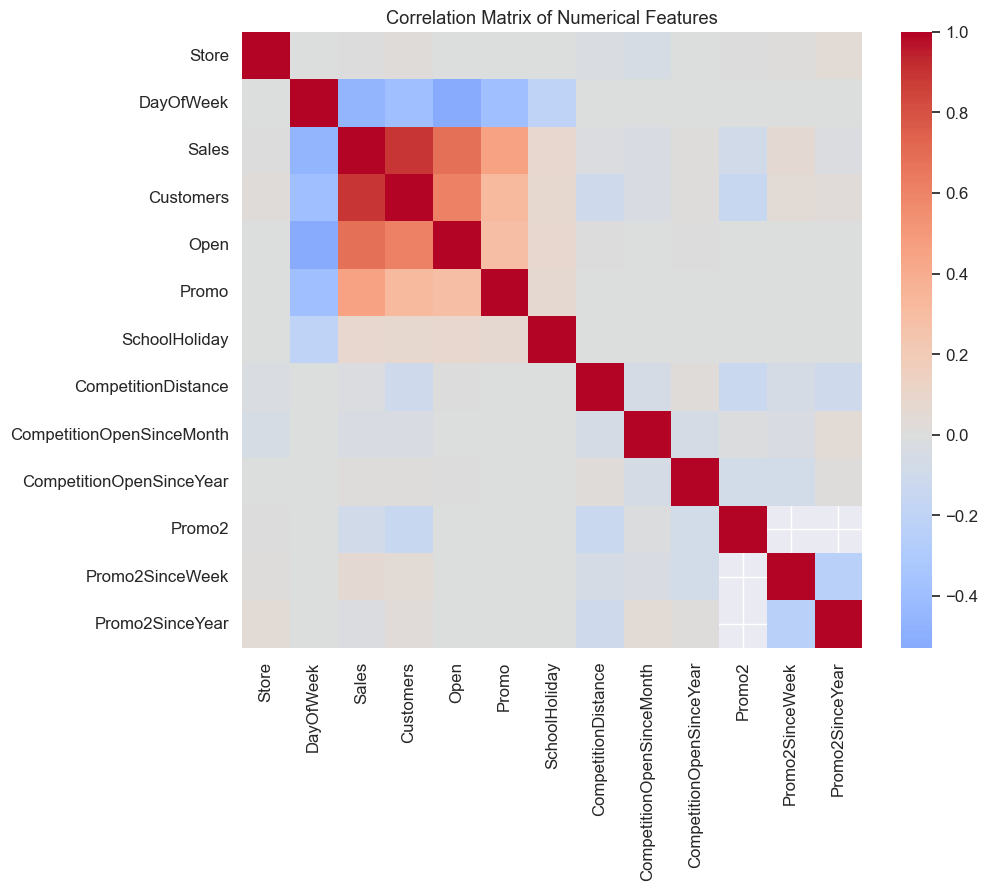

Sales                        1.000000
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
Promo2SinceWeek              0.059558
CompetitionOpenSinceYear     0.012659
Store                        0.005126
CompetitionDistance         -0.019229
Promo2SinceYear             -0.021127
CompetitionOpenSinceMonth   -0.028257
Promo2                      -0.091040
DayOfWeek                   -0.462125
Name: Sales, dtype: float64

In [173]:
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()

# Correlation matrix
corr = merged_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Correlation of features with Sales
corr["Sales"].sort_values(ascending=False)


Key Relationships


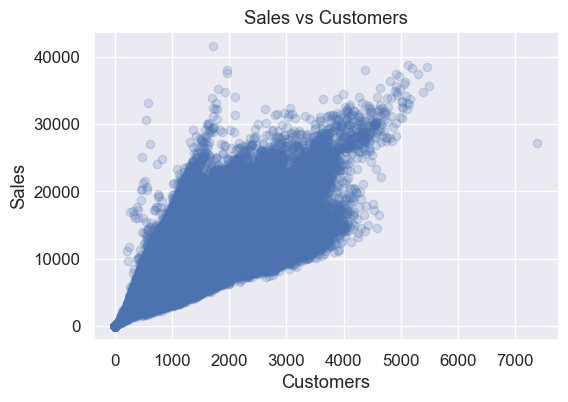

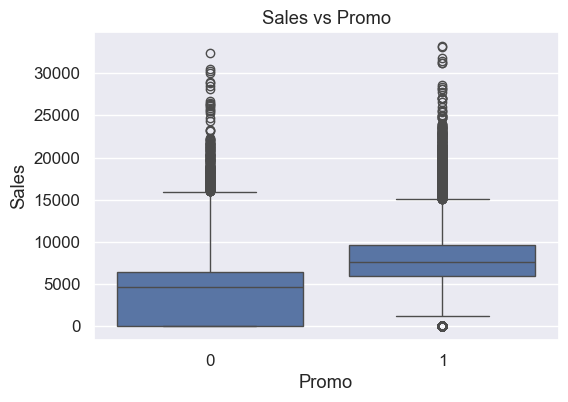

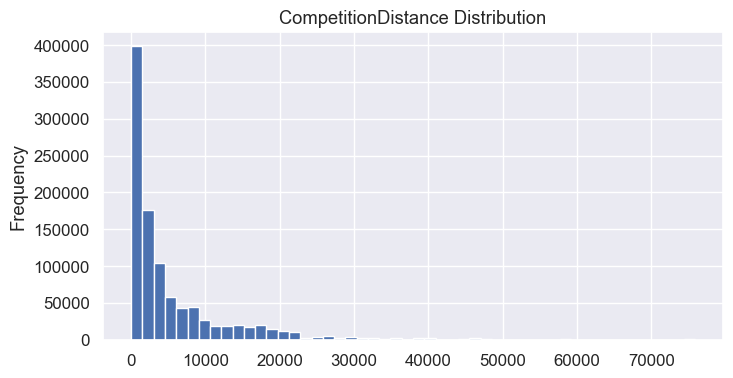

In [174]:
# Sales vs Customers
plt.figure(figsize=(6, 4))
plt.scatter(merged_df["Customers"], merged_df["Sales"], alpha=0.2)
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title("Sales vs Customers")
plt.show()

# Sales vs Promo
plt.figure(figsize=(6, 4))
sns.boxplot(x="Promo", y="Sales", data=merged_df.sample(50000))
plt.title("Sales vs Promo")
plt.show()

# Competition Distance
plt.figure(figsize=(8, 4))
merged_df["CompetitionDistance"].dropna().plot(kind="hist", bins=50)
plt.title("CompetitionDistance Distribution")
plt.show()


## Categorical Features


In [175]:
sample = merged_df.sample(100000, random_state=42)


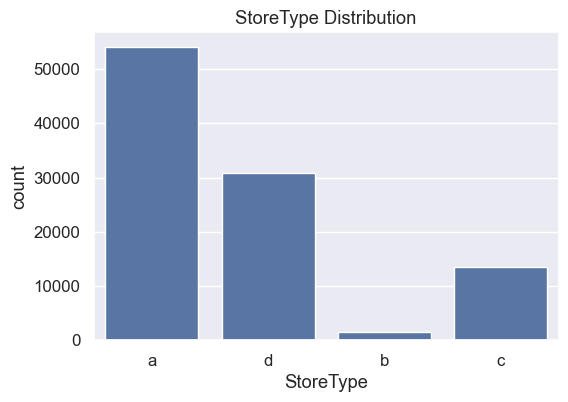

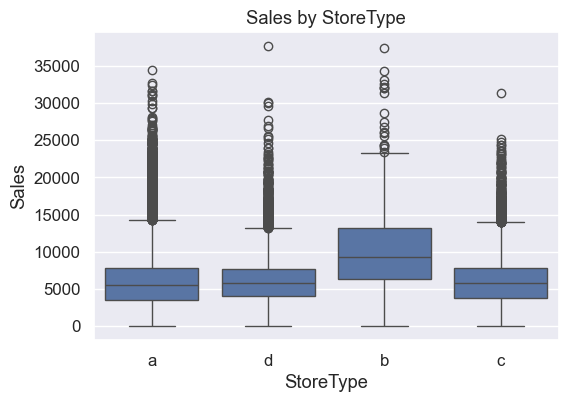

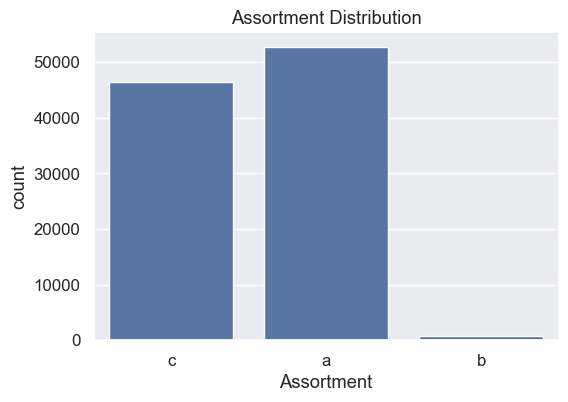

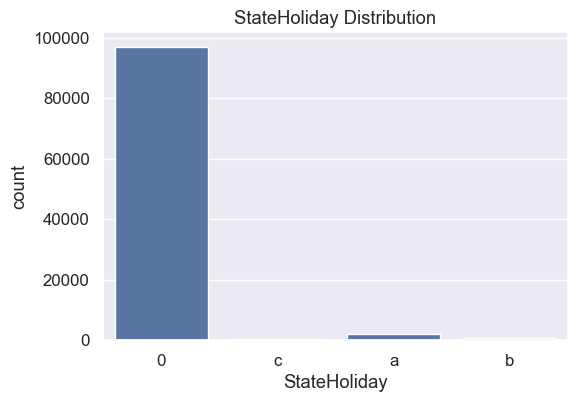

StateHoliday
0    5955.885032
c     331.472155
a     313.936915
b     165.456693
Name: Sales, dtype: float64

In [176]:
plt.figure(figsize=(6, 4))
sns.countplot(x="StoreType", data=sample)
plt.title("StoreType Distribution")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x="StoreType", y="Sales", data=sample)
plt.title("Sales by StoreType")
plt.show()

sample.groupby("StoreType")["Sales"].mean().sort_values(ascending=False)


plt.figure(figsize=(6, 4))
sns.countplot(x="Assortment", data=sample)
plt.title("Assortment Distribution")
plt.show()

sample.groupby("Assortment")["Sales"].mean().sort_values(ascending=False)


plt.figure(figsize=(6, 4))
sns.countplot(x="StateHoliday", data=sample)
plt.title("StateHoliday Distribution")
plt.show()

sample.groupby("StateHoliday")["Sales"].mean().sort_values(ascending=False)



## Time Features & Seasonality


In [177]:
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Month"] = merged_df["Date"].dt.month
merged_df["Day"] = merged_df["Date"].dt.day
merged_df["WeekOfYear"] = merged_df["Date"].dt.isocalendar().week.astype(int)
merged_df["IsWeekend"] = merged_df["DayOfWeek"].isin([6, 7]).astype(int)


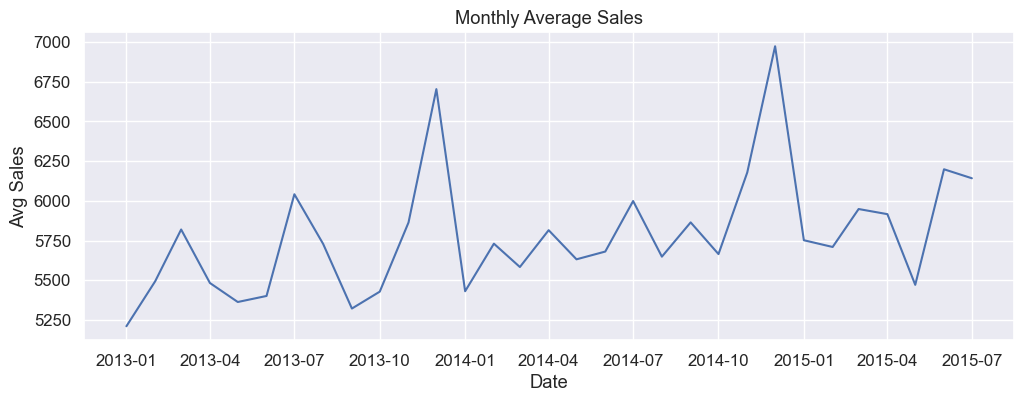

In [178]:
monthly = merged_df.groupby(["Year", "Month"])["Sales"].mean().reset_index()
monthly["YearMonth"] = pd.to_datetime(
    monthly["Year"].astype(str) + "-" +
    monthly["Month"].astype(str) + "-01"
)

plt.figure(figsize=(12, 4))
plt.plot(monthly["YearMonth"], monthly["Sales"])
plt.title("Monthly Average Sales")
plt.xlabel("Date")
plt.ylabel("Avg Sales")
plt.show()


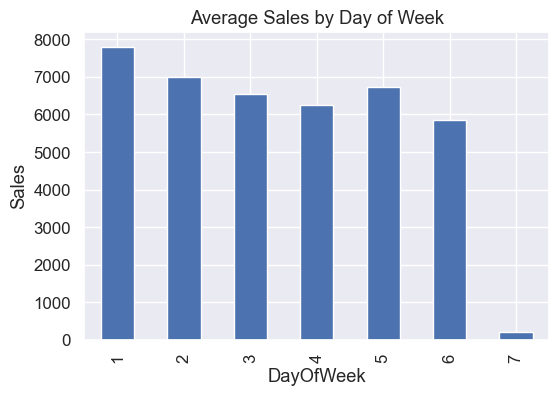

In [179]:
dow_sales = merged_df.groupby("DayOfWeek")["Sales"].mean()

plt.figure(figsize=(6, 4))
dow_sales.plot(kind="bar")
plt.title("Average Sales by Day of Week")
plt.xlabel("DayOfWeek")
plt.ylabel("Sales")
plt.show()


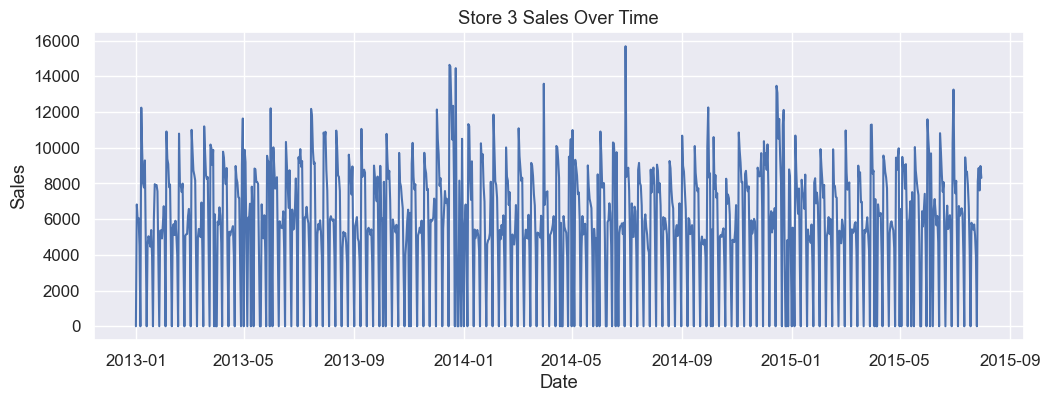

In [180]:
store_id = 3
store_data = merged_df[merged_df["Store"] == store_id]

plt.figure(figsize=(12, 4))
plt.plot(store_data["Date"], store_data["Sales"])
plt.title(f"Store {store_id} Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


## Missing Values Analysis


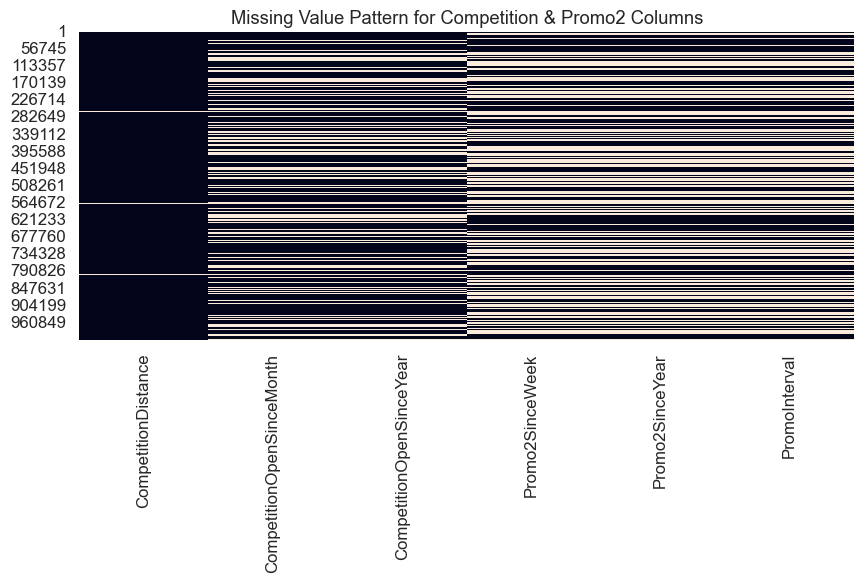

In [255]:
cols = [
    "CompetitionDistance",
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Promo2SinceWeek",
    "Promo2SinceYear",
    "PromoInterval",
]

plt.figure(figsize=(10, 4))
sns.heatmap(merged_df[cols].isna(), cbar=False)
plt.title("Missing Value Pattern for Competition & Promo2 Columns")
plt.show()


## Store Level Aggregation

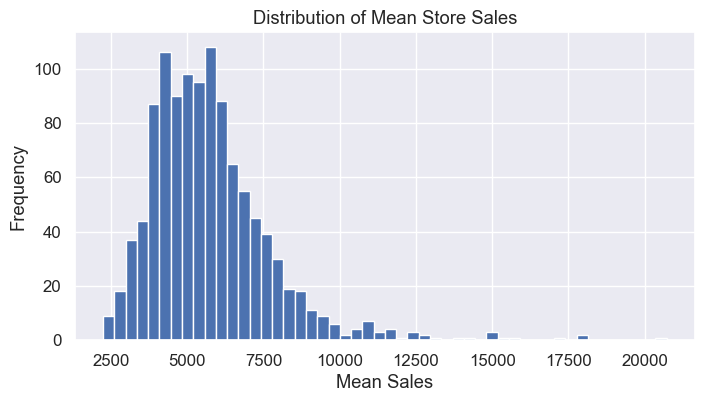

In [182]:
store_stats = merged_df.groupby("Store").agg(
    mean_sales=("Sales", "mean"),
    median_sales=("Sales", "median"),
    mean_customers=("Customers", "mean")
).reset_index()

store_stats.head()


plt.figure(figsize=(8, 4))
plt.hist(store_stats["mean_sales"], bins=50)
plt.title("Distribution of Mean Store Sales")
plt.xlabel("Mean Sales")
plt.ylabel("Frequency")
plt.show()


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [183]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend
0,1,2,2013-01-01,0,0,0,0,a,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,1,1,0
1,1,3,2013-01-02,5530,668,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,2,1,0
2,1,4,2013-01-03,4327,578,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,3,1,0
3,1,5,2013-01-04,4486,619,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,4,1,0
4,1,6,2013-01-05,4997,635,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,5,1,1


In [184]:
def split_date(df):
    # Automatically look for a column that contains 'date' (case-insensitive)
    date_cols = [c for c in df.columns if "date" in c.lower()]

    if not date_cols:
        raise ValueError("No date column found in dataframe.")

    date_col = date_cols[0]  # use the first match

    df[date_col] = pd.to_datetime(df[date_col])
    df["Year"] = df[date_col].dt.year
    df["Month"] = df[date_col].dt.month
    df["Day"] = df[date_col].dt.day
    df["WeekOfYear"] = df[date_col].dt.isocalendar().week.astype(int)

    return df


In [185]:
split_date(merged_df).head(1)
split_date(merged_test_df)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,...,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,...,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17,38
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,...,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,...,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,...,4.0,2006.0,0,NaN,NaN,NaN,2015,8,1,31
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,...,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [186]:
merged_df[merged_df.Open == 0]["Sales"].describe()

count    172817.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Sales, dtype: float64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.


In [187]:
merged_df = merged_df[merged_df["Open"] == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [188]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [189]:
comp_months(merged_df)
comp_months(merged_test_df)

In [190]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
207178,2013-11-11,17410.0,2007.0,4.0,79.0
948568,2015-01-14,4030.0,2013.0,2.0,23.0
976159,2013-02-22,820.0,2012.0,3.0,11.0
1000105,2013-02-28,720.0,2002.0,3.0,131.0
808669,2015-01-08,19700.0,NaN,NaN,0.0
216932,2015-04-13,610.0,NaN,NaN,0.0
793609,2014-01-17,10620.0,NaN,NaN,0.0
874415,2013-04-20,8990.0,NaN,NaN,0.0
1000806,2015-01-30,720.0,2002.0,3.0,154.0
699703,2015-07-15,2630.0,2012.0,9.0,34.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.


In [191]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [192]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [193]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
86171,2013-07-19,0,NaN,NaN,NaN,0.000000,0
287174,2015-01-19,0,NaN,NaN,NaN,0.000000,0
180896,2015-03-10,0,NaN,NaN,NaN,0.000000,0
565175,2014-04-23,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
864226,2013-04-09,0,NaN,NaN,NaN,0.000000,0
136848,2014-12-02,0,NaN,NaN,NaN,0.000000,0
346926,2013-07-10,1,2013.0,5.0,"Feb,May,Aug,Nov",5.278689,0
130089,2015-07-15,0,NaN,NaN,NaN,0.000000,0
975314,2013-05-30,0,NaN,NaN,NaN,0.000000,0
233081,2013-07-29,0,NaN,NaN,NaN,0.000000,0


### Input and Target Columns

Let's select the columns that we'll use for training.

In [194]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [195]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [196]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday',
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [197]:
test_inputs = merged_test_df[input_cols].copy()

Impute missing numerical data

In [203]:
inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [202]:
test_inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [200]:
max_distance = inputs.CompetitionDistance.max()

In [201]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_17016\2526965672.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17016\2526965672.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.


In [204]:
from sklearn.preprocessing import MinMaxScaler

In [205]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="images/encoded.png
" width="640">

Let's one-hot encode categorical columns.

In [226]:
from sklearn.preprocessing import OneHotEncoder

# Beispiel: Encoder einmal auf dem Training fitten
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoder.fit(inputs[categorical_cols])

# ---- TRAIN ----
encoded_train = encoder.transform(inputs[categorical_cols])

encoded_cols = encoder.get_feature_names_out(categorical_cols)

encoded_train_df = pd.DataFrame(
    encoded_train,
    columns=encoded_cols,
    index=inputs.index,   # wichtig, damit die Reihen passen
)

# alte Kategorie-Spalten raus, neue One-Hot-Spalten rein
inputs_encoded = pd.concat(
    [inputs.drop(columns=categorical_cols), encoded_train_df],
    axis=1
)

# ---- TEST ----
encoded_test = encoder.transform(test_inputs[categorical_cols])

encoded_test_df = pd.DataFrame(
    encoded_test,
    columns=encoded_cols,
    index=test_inputs.index,
)

test_inputs_encoded = pd.concat(
    [test_inputs.drop(columns=categorical_cols), encoded_test_df],
    axis=1
)



In [228]:
X = inputs_encoded[numeric_cols + list(encoded_cols)]
X_test = test_inputs_encoded[numeric_cols + list(encoded_cols)]


## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

<img src="images/boosting.png " width="600">


### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.


In [234]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

model.fit(X, targets)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [235]:
preds = model.predict(X)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [239]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b)


### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [240]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [241]:
importance_df.head(10)

,feature,importance
1,Promo,0.334846
12,DayOfWeek_1,0.076257
24,StoreType_b,0.069301
5,Promo2,0.052821
26,StoreType_d,0.051002
9,Month,0.036114
27,Assortment_a,0.034672
11,WeekOfYear,0.034646
29,Assortment_c,0.034157
3,CompetitionDistance,0.030939


## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

In [243]:
from sklearn.model_selection import KFold

In [242]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [244]:
kfold = KFold(n_splits=5)

In [245]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 5903214.0, Validation RMSE: 4727081.5
Train RMSE: 5285733.5, Validation RMSE: 8236486.5
Train RMSE: 5355597.5, Validation RMSE: 8014950.5
Train RMSE: 5238390.5, Validation RMSE: 8251255.5
Train RMSE: 5785925.0, Validation RMSE: 6612328.0


## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.


In [246]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [248]:
test_params(n_estimators=240)

Train RMSE: 794884.375, Validation RMSE: 826872.9375


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [249]:
test_params(max_depth=10)

Train RMSE: 442932.46875, Validation RMSE: 580448.8125


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [250]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1363852.5, Validation RMSE: 1391000.0


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [251]:
test_params(booster='gblinear')

Train RMSE: 7429195.0, Validation RMSE: 7457677.0


## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters.

In [258]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000,
                     learning_rate=0.2, max_depth=10, subsample=0.9,
                     colsample_bytree=0.7)

In [259]:
model.fit(X, targets)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [262]:
test_preds = model.predict(X_test)

submission_df['Sales']  = test_preds

In [263]:
test_df.Open.isna().sum()

np.int64(11)

In [264]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [265]:
submission_df

,Id,Sales
0,1,4094.200439
1,2,7844.475098
2,3,8534.201172
3,4,7103.945801
4,5,7067.401855
...,...,...
41083,41084,2809.326660
41084,41085,7975.461914
41085,41086,7030.519531
41086,41087,22138.863281
